In [1]:
""" 
Goals: Find the candidate features (ICD codes) and response (ICD code)
Ideally, we want features to have different frequencies for different domains

Explore in the following way:
- Target/source features by (frequency, ratio, description)
- Correlation matrix (target vs source feature correlation)

"""

' \nGoals: Find the candidate features (ICD codes) and response (ICD code)\nIdeally, we want features to have different frequencies for different domains\n\nExplore in the following way:\n- Target/source features by (frequency, ratio, description)\n- Correlation matrix (target vs source feature correlation)\n\n'

In [1]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import collections
from common import *
from ast import literal_eval
# %matplotlib notebook
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import random
from select_codes import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score
import seaborn as sns


/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def divide_dataset(df, divide_feature, group_1, group_2):
    """ 
    Divide dataset into group 1 (key value group_1) and group 2 (key value group_2) \
        by dividing feature divide_feature

    Returns: group 1 relative frequency dictionary, group 2 relative frequency dictionary, \
        group 1 total number of codes, group 2 total number of codes \
        total number of unique codes 
    """
    print("df shape is:", df.shape)
    group_1_df = df.loc[df[divide_feature] == group_1]
    print("group_1_df shape is:", group_1_df.shape)
    group_1_codes = []
    for _, row in group_1_df.iterrows():
        group_1_codes.extend(row['ICD codes'])
    group_1_freq_dict = dict(collections.Counter(group_1_codes))
    group_1_total = sum(group_1_freq_dict.values())
    group_1_freq_dict = {k: v / group_1_total for k, v in group_1_freq_dict.items()}

    group_2_df = df.loc[df[divide_feature] == group_2]
    print("group_2_df shape is:", group_2_df.shape)
    group_2_codes = []
    for _, row in group_2_df.iterrows():
        group_2_codes.extend(row['ICD codes'])
    group_2_freq_dict = dict(collections.Counter(group_2_codes))
    group_2_total = sum(group_2_freq_dict.values())
    group_2_freq_dict = {k: v / group_2_total for k, v in group_2_freq_dict.items()}

    unique_codes = list(group_1_freq_dict.keys())
    unique_codes.extend(list(group_2_freq_dict.keys()))
    num_unique_codes = len(list(set(unique_codes)))

    return group_1_freq_dict, group_2_freq_dict, group_1_total, group_2_total, num_unique_codes


In [10]:
def find_differ_codes(dict_1, dict_2, diff_percent):
    """ 
    Find codes in dictionary 1 (dict_1) and and dictionary 2 (dict 2) \
        with relative frequencies differing by diff_percent, 
    
    Returns: the codes differing by diff_percent
    """
    diff_codes = []
    for key, value in dict_1.items():
        # print(key, value)
        if key in dict_2:
            if abs(dict_2[key] - value) > diff_percent:
                diff_codes.append(key)
                print(f"code {key}: dictionary 1 frequency - {value}, dictionary 2 frequency - {dict_2[key]}")
        elif value > diff_percent:
            diff_codes.append
            print(f"code {key}: dictionary 1 frequency - {value}, dictionary 2 frequency - 0")

    for key, value in dict_2.items():
        if key not in dict_1 and value > diff_percent:
            diff_codes.append(key)
            print(f"code {key}: dictionary 1 frequency - 0, dictionary 2 frequency - {value}")

    dict_diff_1 = {}
    dict_diff_2 = {}

    for key, value in dict_1.items():
        if key in diff_codes:
            dict_diff_1[key] = value

    for key, value in dict_2.items():
        if key in diff_codes:
            dict_diff_2[key] = value  

    return diff_codes, dict_diff_1, dict_diff_2


In [6]:
""" 
Read in dataset and select codes
"""

df_path = "/home/wanxinli/EHR-OT/outputs/mimic/ADMID_DIAGNOSIS.csv"
admid_diag_df = pd.read_csv(df_path, index_col=0, header=0, converters={'ICD codes': literal_eval})
admid_diag_df

male_freq_dict, female_freq_dict = construct_freq_dict_group(admid_diag_df, 'gender', 'M', 'F')
male_min_count = 120
female_min_count = 100
selected_codes = select_codes(male_freq_dict, female_freq_dict, male_min_count*2, female_min_count*2)

In [5]:
# preprocess the dataset to keep only the top codes

admid_diag_filtered_df = admid_diag_df.copy(deep=True)
empty_indices = []
for index, row in admid_diag_filtered_df.iterrows():
    codes = row['ICD codes']
    filtered_codes = [code for code in codes if code in selected_codes]
    admid_diag_filtered_df.at[index, 'ICD codes'] = filtered_codes
    if len(filtered_codes) == 0:
        empty_indices.append(index)
admid_diag_filtered_df = admid_diag_filtered_df.drop(empty_indices)
print(admid_diag_filtered_df.shape)
print(admid_diag_df.shape)

all_codes = []
for index, row in admid_diag_filtered_df.iterrows():
    all_codes.extend(row['ICD codes'])


data_path = "../../outputs/mimic/ADMID_DIAGNOSIS_selected.csv"
admid_diag_filtered_df.to_csv(data_path, index=True, header=True)
admid_diag_filtered_df


(57734, 6)
(58976, 6)


,adm_type,gender,ICD codes,duration,diagnosis,label
admid,,,,,,
172335,EMERGENCY,F,"[486, 425.4, 276.2, 276.7, 458.29, 287.5, 285....",530460.0,LEG PAIN,0
173633,EMERGENCY,F,"[585.6, 583.81, 287.5, 285.21, 458.29, 327.23,...",574560.0,ABDOMINAL PAIN,0
174105,EMERGENCY,M,"[410.71, 285.9, 414.01]",425460.0,GASTROINTESTINAL BLEED,0
109976,EMERGENCY,M,"[331.4, 530.81]",1284240.0,HYDROCEPHALUS,0
178393,ELECTIVE,M,"[414.01, 411.1, 285.9, 272.0, 305.1]",485280.0,USA/SDA,0
...,...,...,...,...,...,...
172304,ELECTIVE,F,"[348.5, 401.9, 272.0, 530.81]",449700.0,LEFT BRAIN TUMOR/SDA,0
152542,EMERGENCY,M,"[357.2, V58.67, 427.31, 401.9, 428.0, 530.81, ...",415740.0,PERIRECTAL ABSCESS,0
161999,EMERGENCY,M,"[434.11, 348.5, 348.4, 430, 348.30, 997.31, 59...",692940.0,STROKE;TELEMETRY,0


# Divide by gender

In [13]:
""" 
Calculates ICD code frequencies for target and source
"""
male_freq_dict, female_freq_dict, male_total, female_total, num_unique_codes = divide_dataset(admid_diag_df, 'gender', 'M', 'F')
print("male total number of code is:", male_total)
print("female total number of code is:", female_total)
print("number of unique codes is:", num_unique_codes)
avg_percent = 1/num_unique_codes
print("avg percent is:", avg_percent)

df shape is: (58976, 6)
group_1_df shape is: (32950, 6)
group_2_df shape is: (26026, 6)
male total number of code is: 362773
female total number of code is: 288274
number of unique codes is: 6985
avg percent is: 0.00014316392269148176


In [14]:
# Find frequencies in female and male dictionaries differing by diff_percent
diff_codes, male_diff_dict, female_diff_dict = find_differ_codes(male_freq_dict, female_freq_dict, 10*avg_percent)
print("number of differing codes is:", len(diff_codes))

# report the statistics in REB application

code 285.9: dictionary 1 frequency - 0.007379270232349155, dictionary 2 frequency - 0.009466687942721161
code 414.01: dictionary 1 frequency - 0.022347308096247517, dictionary 2 frequency - 0.014992680574730985
code 411.1: dictionary 1 frequency - 0.003299584037400799, dictionary 2 frequency - 0.0016165176186544745
code 305.1: dictionary 1 frequency - 0.0058080397383487746, dictionary 2 frequency - 0.004339621332482291
code 599.0: dictionary 1 frequency - 0.006968545068128003, dictionary 2 frequency - 0.013969348605840277
code 274.9: dictionary 1 frequency - 0.004217513431264179, dictionary 2 frequency - 0.0019148449045005792
code V10.46: dictionary 1 frequency - 0.003327149484663963, dictionary 2 frequency - 0
code 428.33: dictionary 1 frequency - 0.0012156362243055574, dictionary 2 frequency - 0.002702290182257158
code 428.0: dictionary 1 frequency - 0.01930959580784678, dictionary 2 frequency - 0.021181237295073436
code V45.81: dictionary 1 frequency - 0.005954136608843546, dictiona

In [15]:
# Find frequency difference for the filtered dataframe
male_freq_dict, female_freq_dict, male_total, female_total, num_unique_codes = divide_dataset(admid_diag_filtered_df, 'gender', 'M', 'F')
avg_percent = 1/num_unique_codes
print("avg percent is:", avg_percent)

diff_codes, male_diff_dict, female_diff_dict = find_differ_codes(male_freq_dict, female_freq_dict, avg_percent)
print("number of differing codes is:", len(diff_codes))

df shape is: (57734, 6)
group_1_df shape is: (32167, 6)
group_2_df shape is: (25567, 6)
avg percent is: 0.004032258064516129
code 414.01: dictionary 1 frequency - 0.033854068793873114, dictionary 2 frequency - 0.02280690645052347
code 599.0: dictionary 1 frequency - 0.010556690009980415, dictionary 2 frequency - 0.021250211077338738
code V10.46: dictionary 1 frequency - 0.005040318371062643, dictionary 2 frequency - 0
code V45.81: dictionary 1 frequency - 0.00901995665409719, dictionary 2 frequency - 0.004728132387706856
code 244.9: dictionary 1 frequency - 0.006723208431989109, dictionary 2 frequency - 0.0174508189800743
code 600.00: dictionary 1 frequency - 0.006222099728983709, dictionary 2 frequency - 0
code V50.2: dictionary 1 frequency - 0.00841862621049071, dictionary 2 frequency - 0
code 733.00: dictionary 1 frequency - 0.0012945308160972819, dictionary 2 frequency - 0.008638340087808173
number of differing codes is: 5


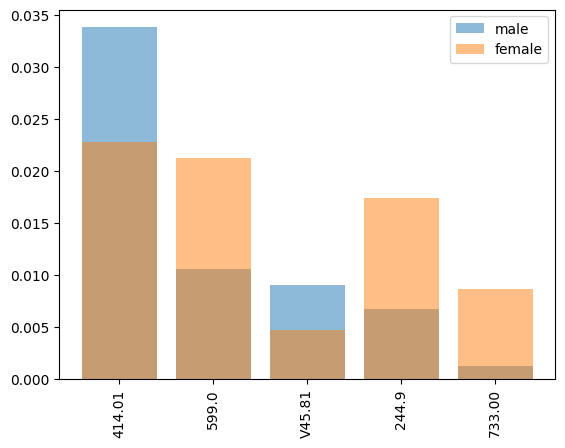

In [16]:
# visualize differing codes
plt.bar(list(male_diff_dict.keys()), list(male_diff_dict.values()), alpha=0.5, label="male")
plt.bar(list(female_diff_dict.keys()), list(female_diff_dict.values()), alpha=0.5, label="female")
plt.xticks(rotation = 90) 
plt.legend()
plt.show()

# Divide by admission type

In [17]:
""" 
Calculate the number of emergency, elective and newborn
"""
types = list(admid_diag_df['adm_type'])
print("emergency count is:", types.count('EMERGENCY'))
print("elective count is:", types.count('ELECTIVE'))
print("newborn count is:", types.count('NEWBORN'))

emergency count is: 42071
elective count is: 7706
newborn count is: 7863


In [18]:
emergency_freq_dict, elective_freq_dict, emergency_total, elective_total, num_unique_codes \
    = divide_dataset(admid_diag_df, 'adm_type', 'EMERGENCY', 'ELECTIVE')
avg_percent = 1/num_unique_codes
print("avg percent is:", avg_percent)

df shape is: (58976, 6)
group_1_df shape is: (42071, 6)
group_2_df shape is: (7706, 6)
avg percent is: 0.0001502178158329578


In [19]:
# Find frequencies in emergency and elective dictionaries differing by diff_percent
diff_codes = find_differ_codes(emergency_freq_dict, elective_freq_dict, 10*avg_percent)
print("number of differing codes is:", len(diff_codes))

code 486: dictionary 1 frequency - 0.008593060253812108, dictionary 2 frequency - 0.0034813231716332646
code 276.2: dictionary 1 frequency - 0.007862804683681493, dictionary 2 frequency - 0.005000201621033106
code 276.7: dictionary 1 frequency - 0.0038386714757924142, dictionary 2 frequency - 0.0019490033200263452
code 458.29: dictionary 1 frequency - 0.002633170217164097, dictionary 2 frequency - 0.009771899404545882
code 285.21: dictionary 1 frequency - 0.002511460955475661, dictionary 2 frequency - 0.0009812223611167117
code 585.6: dictionary 1 frequency - 0.0034407015090016555, dictionary 2 frequency - 0.0016801752758847802
code 327.23: dictionary 1 frequency - 0.0037304854654026933, dictionary 2 frequency - 0.00565883032917994
code 410.71: dictionary 1 frequency - 0.00546918920380892, dictionary 2 frequency - 0.001155960589808729
code 414.01: dictionary 1 frequency - 0.018289231434990835, dictionary 2 frequency - 0.03294487680954877
code 530.81: dictionary 1 frequency - 0.00936581

In [20]:
# Find frequency difference for the filtered dataframe
emergency_freq_dict, elective_freq_dict, emergency_total, elective_total, num_unique_codes \
    = divide_dataset(admid_diag_filtered_df, 'adm_type', 'EMERGENCY', 'ELECTIVE')
avg_percent = 1/num_unique_codes
print("avg percent is:", avg_percent)

diff_codes, emergency_diff_dict, elective_diff_dict,  = find_differ_codes(emergency_freq_dict, elective_freq_dict, avg_percent)
print("number of differing codes is:", len(diff_codes))

df shape is: (57734, 6)
group_1_df shape is: (41074, 6)
group_2_df shape is: (7496, 6)
avg percent is: 0.004048582995951417
code 486: dictionary 1 frequency - 0.013250517598343685, dictionary 2 frequency - 0.005091109232795392
code 276.2: dictionary 1 frequency - 0.012124461921146313, dictionary 2 frequency - 0.007312326774516934
code 458.29: dictionary 1 frequency - 0.004060354201111161, dictionary 2 frequency - 0.014290488078155406
code 410.71: dictionary 1 frequency - 0.008433501645888259, dictionary 2 frequency - 0.0016904841467969257
code 414.01: dictionary 1 frequency - 0.028202034645575465, dictionary 2 frequency - 0.04817879818371238
code 530.81: dictionary 1 frequency - 0.014442110907547254, dictionary 2 frequency - 0.02541623257916773
code 424.0: dictionary 1 frequency - 0.006121810626033335, dictionary 2 frequency - 0.01513573015155387
code 599.0: dictionary 1 frequency - 0.01783219387223141, dictionary 2 frequency - 0.008118255263106167
code 428.0: dictionary 1 frequency - 

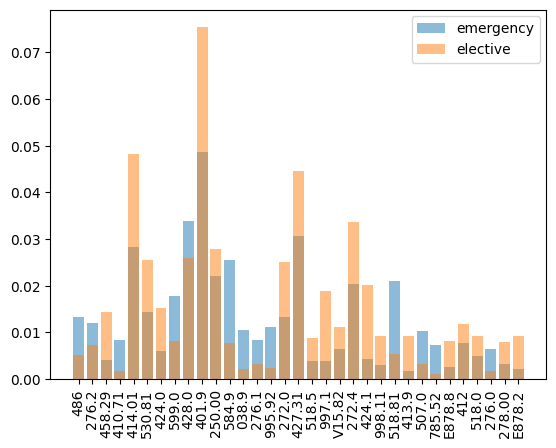

In [21]:
# visualize differing codes
plt.bar(list(emergency_diff_dict.keys()), list(emergency_diff_dict.values()), alpha=0.5, label="emergency")
plt.bar(list(elective_diff_dict.keys()), list(elective_diff_dict.values()), alpha=0.5, label="elective")
plt.xticks(rotation = 90) 
plt.legend()
plt.show()